Librerías

In [ ]:
import os, random, gc
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from torchvision import datasets
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

**Librerías del sistema y maneho de memoria**  
os -- para interactuar con el sistema operativo (leer ruta de archivos, crear carpetas, listar imágenes)  
random -- genera números aleatorios (muestrear datos aleatoriamente)  
gc -- Libera memoria manualmente. En deep learning se usa cuando se entrena en GPU y querés evitar que la RAM/VRAM quede ocupada por objetos ya no usados. Ejemplo: gc.collect() limpia variables grandes o tensores que ya no necesitás.  
**Librerías numéricas y de análisis**  
numpy -- manipulación de arrays. Las imágenes se representan como arrays 3D (altura x ancho x canales). Ej: convertir una imágen a array  
pandas -- Manejo de datos tabulares (tipo Excel). Manejo de los metadatos, archivo CSV.  
PIL (Python Imaging Library) -- Carga y manipulación básica de imágenes. Abrir, redimensionar o convertir imágenes antes de transformarlas a tensores.  
**PyTorch**  
torch -- maneja tensores (análogos a arrays de NumPy pero en GPU) y operaciones sobre ellos.  
torch.nn -- Módulo de neural networks. Contiene todas las capas y funciones de activación, como nn.Conv2d, nn.Linear, nnReLU. Se usa para definir la arquitectura del modelo.  
torch.optim -- Optimizadores (SGD, Adam). Controlan cómo se ajustan los pesos del modelo durante el entrenamiento.  
torch.utils.data.Dataset -- Crear un conjunto de datos propio. Definir como se carga y transforma cada imagen individualmente.  
torch.utils.data.DataLoader -- Crear los barches y mezcla los datos. Permite un entrenamiento más eficiente y escalable.  
**Métricas y balanceo de clases**  
scikit-learn (sklearn): para tareas de evaluación  
classification_report -- Genera métricas como precision, recall, f1-score y accuracy por clase.  
train_test_split -- Divide los datos en entrenamiento y validación/test.  
compute_class_weight -- Calcula pesos inversos al nímero de muestras por clase. Usado para el desbalance (nn.CrossEntropyLoss (weight=...)).  
**Modelos preentrenados y datasets**  
torchvision.datasets -- Contiene datasets clásicos (ImageNet)
timm (PyTorch Image Models) -- Librería con modelos preentrenados de vision (Vit, ResNet, etc). timm.create_model("vit_base_patch16_224", pretrained=True).  
**Aumentación de datos (Data Augmentation)**
albumentations -- Librería avanzada de data augmentation. Aplica transformaciones como rotaciones, recortes, contraste, flips, etc. Más potente y rápida que torchvision.transforms.  
ToTensorV2 -- Convierte la imagen (numpy) a tensor de PyTorch



In [ ]:
# ==============================
# CONFIGURACIÓN
# ==============================
class CFG:
    seed: int = 42 #semilla aleatoria para obtener resultados reproducibles
    img_size: int = 224 #tamaño al que se redimensionan las imágenes antes de ingresarlas al modelo
    batch_size = 32 # número de imágenes que se procesan simultáneamente en una pasada. Afecta la velocidad de entrenamiento y el uso de memoria GPU.
    num_workers = 0 # Define cuantos subprocesos paralelos usa el DataLoader para cargar datos. 0: todo se carga en el proceso principal.
    num_epochs: int = 50 # n° de veces que el modelo recorrerá todo el dataset de entrenamiento
    lr_head: float = 1e-4      # para la cabeza (clasificador)
    lr_finetune: float = 1e-5  # para todo el modelo (el cuerpo del modelo preentrenado)
    model_name: str = "vit_base_patch16_224" # Vision Transformer base con patches de 16x16 px y entradas de 224x224
    pretrained: bool = True # Indica que se cargan pesos preentrenados en ImageNet.

    if os.path.exists("/scratch/llencinas/Clasificado_menosNEVOS"):
        images_root: str = "/scratch/llencinas/Clasificado_menosNEVOS"
    elif os.path.exists("/users/llencinas/Clasificado_menosNEVOS"):
        images_root: str = "/users/llencinas/Clasificado_menosNEVOS"
    elif os.path.exists("/content/Clasificado_local"):
        images_root: str = "/content/Clasificado_local"
    else:
        raise FileNotFoundError("No se encontró el dataset.")

    val_split: float = 0.1 # 10% de los datos se reserva para validación
    test_split: float = 0.1 # 10% se reserva para test final
    device: str = "cuda" if torch.cuda.is_available() else "cpu" #detecta si hay GPU disponible (CUDA = tecnología de NVIDIA)


def set_seed(seed=42): # Función para garantizar reproductibilidad
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CFG.seed)

Learning rate (tasa de aprendizaje) controla que tan grandes son los pasos que da el optimizador al ajustar los pesos del modelo durante el entrenamiento.  
- Si el LR es muy alto, el modelo puede saltar el mínimo y no converger.
- Si es muy bajo, aprende demasiado lento o se queda atascado

Divido el LR porque ViT tiene 2 partes distintas:
1. La base o cuerpo preentrenado  
  Parte que viene entrenada en ImageNet
    * Contiene los bloques transformadores y pesos que ya aprendieron a reconocer patrones visuales generales (bordes, texturas, colores, formar).
    * Estos pesos no deben cambiar demasiado porque ya contienen información útil.
   
   Se usa un LR más chico: 1e-5. Ajusta lentamente los pesos del modelo base, haciando una adaptación suave al nuevo dataset (fine-tuning).
2. Cabeza o head classifier  
  Capa final que se agrega para adaptar el modelo a nuestro fin (5 clases).
  * Esta capa se inicializa desde cero, con pesos aleatorios.
  * No tiene conocimiento previo, así que necesita aprender rápido.

  Se usa un LR mayor: 1e-4. Así la cabeza puede aprender con pasos más grandes y adaptarse rápidamente, mientras que el cuerpo del modelo cambia más despacio.

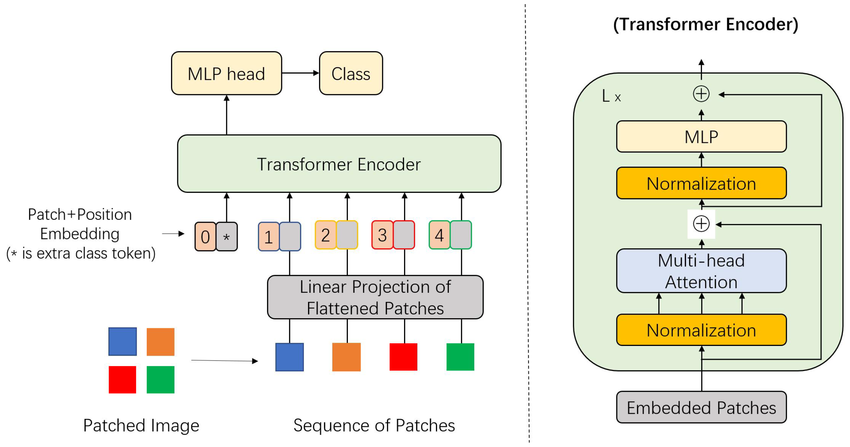

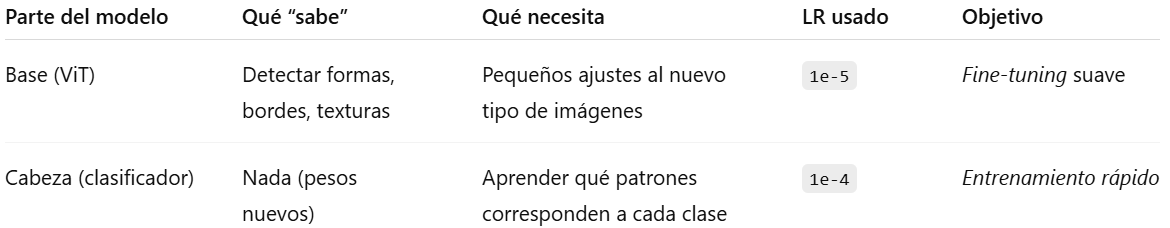

In [ ]:
# ==============================
# AUMENTACIONES
# ==============================
transform_major = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(size=(CFG.img_size, CFG.img_size), scale=(0.8, 1.0), p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

transform_minor = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(0.3,0.3,0.3,0.1,p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomResizedCrop(size=(CFG.img_size, CFG.img_size), scale=(0.6, 1.0), p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

Aumentaciones: transformaciones aleatorias que se le aplican a las imágenes de entrenamiento para "crear" versiones ligeramente distintas de los mismos datos.  
Objetivo -- que el modelo no memorice las imágenes exactas, sino que aprenda los patrones generales.  
```
A.Compose([...])
```
Para componer varias transformaciones, que se aplican en secuencia a cada imagen.  
Primero se redimensiona - luego se hace un flip - luego se normaliza - finalmente se convierte en tensor.

**Tres conjuntos de transformaciones**
1. transform_major = aumentaciones fuertes, para clases minoritarias
2. transform_minor = aumentaciones moderadas, para clases mayoritarias
3. val_tfms = transformaciones neutras (solo para validación/test). No se aplican transformaciones, solo se prepara la imagen.


*Transformaciones mayores:*  
Se usa para las clases mayoritarias (Nevo, Dermatosis cancerosa), que tienen muchas imágenes.
*Transformaciones menores:*  
Se usa para las clases minoritarias (Otras lesiones, Dermatosis precancerosa y Tumores benignos), aplicando transformaciones más fuertes y variadas para generar imágenes artificialmente diferentes y equilibrar el dataset.

Anteriormente, realizamos un primer entrenamiento sin esta diferenciación y obtuvimos buen rendimiento para las clases mayoritarias pero uno muy malo para las minoritarias, por este motivo decidimos separar.  
Esta técnica permite mitigar el desbalance de clases sin necesidad de sobre-muestrear o duplicar imágenes, mejorando la capacidad del modelo para generalizar en las clases menos representadas.

*Conclusiones de la Prueba 0 de Vit: https://colab.research.google.com/drive/1R_JizubaV47iXy8Df31JJlTGqdMIE-cE*

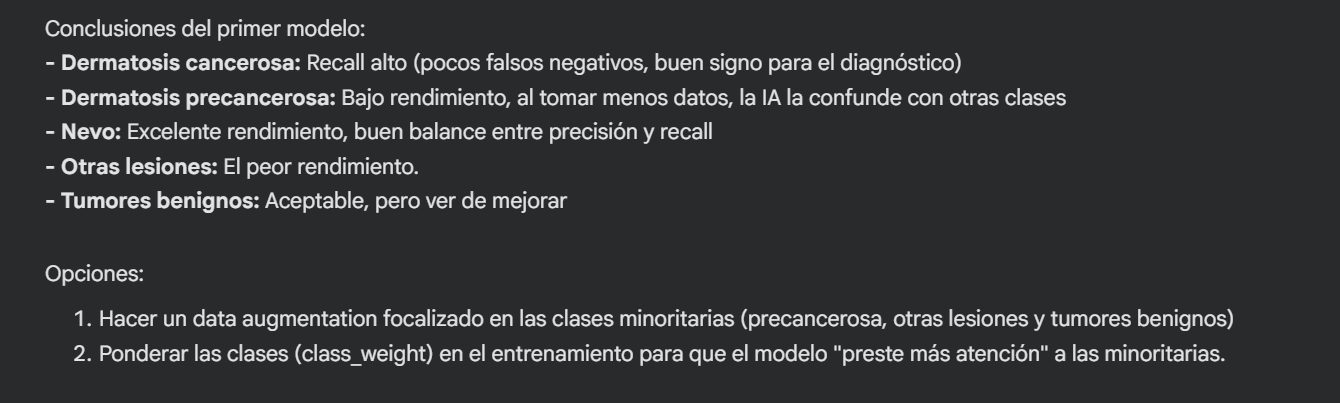

In [ ]:
# ==============================
# DATASET Y DATALOADERS
# ==============================
full_ds = datasets.ImageFolder(CFG.images_root)
X = [s[0] for s in full_ds.samples]
y = [s[1] for s in full_ds.samples]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=CFG.val_split+CFG.test_split, stratify=y, random_state=CFG.seed)
relative_test_size = CFG.test_split / (CFG.val_split + CFG.test_split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=relative_test_size, stratify=y_temp, random_state=CFG.seed)

major_classes = [full_ds.class_to_idx[c] for c in ["Nevo", "Dermatosis cancerosa"]]

class CustomImageDataset(Dataset):
    def __init__(self, paths, labels, major_classes, transform_major, transform_minor, transform_val=None):
        self.paths = paths
        self.labels = labels
        self.major_classes = major_classes
        self.transform_major = transform_major
        self.transform_minor = transform_minor
        self.transform_val = transform_val

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        img = np.array(Image.open(path).convert("RGB"))
        if self.transform_val is None:
            if label in self.major_classes:
                img = self.transform_major(image=img)["image"]
            else:
                img = self.transform_minor(image=img)["image"]
        else:
            img = self.transform_val(image=img)["image"]
        return img, label

    def __len__(self):
        return len(self.paths)

train_ds = CustomImageDataset(X_train, y_train, major_classes, transform_major, transform_minor)
val_ds   = CustomImageDataset(X_val, y_val, major_classes, transform_major, transform_minor, transform_val=val_tfms)
test_ds  = CustomImageDataset(X_test, y_test, major_classes, transform_major, transform_minor, transform_val=val_tfms)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
val_loader   = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
test_loader  = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

class_names = full_ds.classes

```
datasets.ImageFolder
```
Carga todas las imágenes que están organizadas en carpetas por clase. ImageFolder automáticamente asigna clases, ej: Nevo - clase 0.




En esta sección se prepara el conjunto de datos que alimentará al modelo durante el entrenamiento, valición y prueba.  
Primero se cargan todas las imágenes utilizando ImageFolder, que organiza automáticamente las clases según el nombre de las carpetas. De cada imagen se extrae su ruta y su etiqueta numérica correspondiente.  
Luego, se dividen los datos en tres subconjuntos:
* Entrenamiento (train): utilizado para ajustar los parámetros del modelo.
* Validación (val): permite evaluar el rendimiento durante el entrenamiento y ajustar hiperparámetros.
* Prueba (test): se usa al final, para obtener la métrica real de desempeño del modelo.  

*Custom Dataset*

Se crea una clase personalizada llamada `CustomImageDataset`, basada en
`torch.utils.data.Dataset`, que define cómo cargar cada imagen, su etiqueta y qué tipo de aumentación aplicar:
- Si la imagen pertenece a una clase mayoritaria, se aplica transform_major.
- Si pertenece a una clase minoritaria, se aplica transform_minor.
- En validación o prueba, se usa val_tfms, que solo realiza resize y normalización, sin aumentaciones aleatorias.

*Dataloaders*

Los DataLoader agrupan las imágenes en lotes (batch_size) y permiten que el modelo las procese de manera eficiente:

- En entrenamiento (train_loader) las imágenes se mezclan aleatoriamente (shuffle=True), para mejorar la generalización.
- En validación y prueba (val_loader, test_loader), el orden se mantiene (shuffle=False) para obtener resultados consistentes.

In [ ]:
# ==============================
# MODELO (ViT + DROPOUT + LABEL SMOOTHING)
# ==============================
model = timm.create_model(
    CFG.model_name,
    pretrained=CFG.pretrained,
    num_classes=len(class_names),
    drop_rate=0.3,
    attn_drop_rate=0.3
).to(CFG.device)

Se crea el modelo principal que se va a entrenar.  
`timm.create_model` -- timm es una librería que contiene el ViT, se carga según `CFG.model_name` (Vit base patch 16 224).  
`pretrained=CFG.pretrained` -- se cargan pesos preentrenados. Esto ayuda a que el modelo converja más rápido, generalice mejor y requiera menos datos.  
`num_classes=len(class_names)` -- define cuantas clases debe predecir la capa final del modelo (5), se ajusta automáticamente según la cantidad de carpetas que encuentra ImageFolder.  
`Dropout - drop_rate=0,3` -- Agrego un dropout del 30% en las capas de MLP de cada bloque del ViT. Objetivo: evitar el sobreajuste (overfitting). Durante el entrenamiento, se apaga un porcentaje de neuronas para obligar al modelo a aprender representaciones robustas.  
`Attention Dropout - attn_drop_rate=0.3` -- aplica dropout dentro del mecanismo de atención. Ayuda a evitar que el modelo "memorice" patrones específicos, mejorar la regularización y estabilizar la atención cuando el dataset es pequeño o desbalanceado.  
`.to(CFG.device)` -- mueve el modelo a GPU si esta disponible.

In [ ]:
# ==============================
# FUNCIÓN DE ENTRENAMIENTO Y EVALUACIÓN
# ==============================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

Se definen dos funciones principales:
`train_one_epoch` para entrenar el modelo durante una época
y `eval_one_epoch` para evaluar el rendimiento sin modificar los pesos.

`train_one_epoch — Entrenamiento`

Esta función realiza un ciclo completo de entrenamiento sobre todos los batches del train_loader.

- `model.train()` — coloca el modelo en modo entrenamiento. Activa dropout, batchnorm, etc.

- Se inicializan contadores de pérdida total, aciertos y muestras procesadas.

- En cada iteración del DataLoader:
  - Se envían las imágenes y etiquetas a GPU con .to(CFG.device).
  - optimizer.zero_grad() — limpia gradientes acumulados de la iteración anterior.
  - outputs = model(imgs) — el modelo hace una predicción para cada imagen.
  - loss = criterion(outputs, labels) — calcula la pérdida (por ejemplo, Cross Entropy con Label Smoothing).
  - loss.backward() — calcula los gradientes mediante backpropagation.
  - optimizer.step() — actualiza los pesos del modelo usando esos gradientes.

Luego se calcula:
- loss total del epoch
- accuracy, comparando predicciones (preds) con etiquetas reales.

La función devuelve el loss promedio y la precision (accuracy) del epoch.

`eval_one_epoch — Evaluación`

Se utiliza para medir el rendimiento del modelo en validación o test.

- model.eval() — activa modo evaluación (desactiva dropout, batchnorm no se actualiza).
- torch.no_grad() — evita calcular gradientes (acelera y reduce memoria).
- Procesa cada batch igual que en entrenamiento, pero sin actualizar pesos.

Calcula:
- pérdida promedio del conjunto
- accuracy global

Devuelve el loss y la accuracy del conjunto evaluado.

In [ ]:
# ==============================
# ENTRENAMIENTO EN DOS FASES
# ==============================
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(weights, dtype=torch.float).to(CFG.device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

# Fase 1: entrenar solo la cabeza
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.head.parameters(), lr=CFG.lr_head, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

print("Fase 1: entrenamiento de cabeza")
for epoch in range(5):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    scheduler.step()
    print(f"[F1] Epoch {epoch+1}/5 - Train acc: {tr_acc:.4f} | Val acc: {val_acc:.4f}")

# Fase 2: fine-tuning completo
del optimizer, scheduler
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=CFG.lr_finetune, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.num_epochs)

best_acc = 0
patience = 7
trigger_times = 0

print("Fase 2: fine-tuning completo")
for epoch in range(CFG.num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    scheduler.step()

    print(f"Epoch {epoch+1}/{CFG.num_epochs} - Train loss {tr_loss:.4f}, acc {tr_acc:.4f} | Val loss {val_loss:.4f}, acc {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit35.pth")
        print(f"\ Nuevo mejor modelo guardado (acc={val_acc:.4f})")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"EarlyStopping activado en epoch {epoch+1}")
            break

print("Entrenamiento finalizado. Mejor acc:", best_acc)

*Cálculo de pesos para clases desbalanceadas*  
`weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)`  
`weights = torch.tensor(weights, dtype=torch.float).to(CFG.device)`  
`criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)`  

- `compute_class_weight` calcula un peso mayor para las clases que tienen menos muestras, y un peso menor para las clases abundantes. Esto evita que el modelo favorezca siempre a la clase mayoritaria.
- Se convierte el array de pesos a tensor y se lo envía a GPU.
- `CrossEntropyLoss(weight=weights)` obliga al modelo a penalizar más fuerte los errores en clases minoritarias.
- `label_smoothing=0.1` distribuye 10% del valor real entre las demás clases, evitando que el modelo se vuelva demasiado seguro y ayudando a la generalización.

*FASE 1 — Entrenamiento solo de la cabeza (head)*
`
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True
`

Se congelan todos los parámetros del ViT, es decir, no se actualizan las capas internas del transformer.

Solo se descongelan los parámetros de la cabeza (la última capa lineal que predice las clases).

Esta capa está inicializada aleatoriamente, así que necesita entrenarse primero antes de modificar el resto del modelo.

`optimizer = optim.AdamW(model.head.parameters(), lr=CFG.lr_head, weight_decay=1e-4)`

El optimizador solo recibe los parámetros de la cabeza.
- lr_head (learning rate), se usa un LR más alto porque la cabeza es nueva y necesita aprender desde cero rápidamente.
- AdamW ayuda a entrenar modelos grandes con mejor regularización.

`scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)`
- Reduce gradualmente la LR durante los 5 epochs de la Fase 1.
- La programación cíclica evita saltos bruscos en el aprendizaje.

`print("Fase 1: entrenamiento de cabeza")
for epoch in range(5):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    scheduler.step()
    print(f"[F1] Epoch {epoch+1}/5 - Train acc: {tr_acc:.4f} | Val acc: {val_acc:.4f}")
`  
Se entrenan 5 epochs únicamente en la cabeza.
En cada epoch:
- se calcula pérdida y accuracy en entrenamiento,
- se evalúa en validación,
- se ajusta la LR.

Esta fase permite que el modelo adapte sus salidas a la estructura de tu dataset antes de tocar el resto del ViT.

*FASE 2 — Fine-tuning completo del modelo*  
`
del optimizer, scheduler
for param in model.parameters():
    param.requires_grad = True
`

Se elimina el optimizador de la Fase 1.

Se descongela todo el modelo, incluyendo bloques de atención, embeddings y MLP internos del ViT.

Desde este momento, cada capa del transformer se va a ajustar al dataset.

`optimizer = optim.AdamW(model.parameters(), lr=CFG.lr_finetune, weight_decay=1e-4)`

Ahora el optimizador entrena todos los parámetros del ViT.

La LR utilizada es lr_finetune, mucho más pequeña que lr_head.
Motivo: el ViT está preentrenado en millones de imágenes, y un LR grande destruiría ese conocimiento.
Aquí solo se realiza un ajuste fino (fine-tuning).

`scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.num_epochs)`

Se programa una reducción suave de la LR a lo largo de toda la Fase 2.

Ayuda a estabilizar el entrenamiento en las últimas épocas.  

*Entrenamiento con Early Stopping*  
best_acc = 0
patience = 7
trigger_times = 0


Se inicializa el control de early stopping.

paciencia = 7 → si pasan 7 epochs sin mejorar la accuracy en validación, se detiene el entrenamiento para evitar overfitting.

print("Fase 2: fine-tuning completo")
for epoch in range(CFG.num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    scheduler.step()


Cada epoch:
- Se entrena todo el ViT.
- Se evalúa en validación.
- Se ajusta la LR.

*Guardado del mejor modelo*
if val_acc > best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), "best_vit35.pth")
    print(f"\ Nuevo mejor modelo guardado (acc={val_acc:.4f})")
    trigger_times = 0


Cada vez que la accuracy de validación mejora, se guarda el modelo.

Se reinicia el contador de early stopping.

else:
    trigger_times += 1
    if trigger_times >= patience:
        print(f"EarlyStopping activado en epoch {epoch+1}")
        break


Si pasan demasiadas épocas sin mejora:
- Se activa early stopping.
- Se corta el entrenamiento para evitar sobreajuste.

print("Entrenamiento finalizado. Mejor acc:", best_acc)


Muestra la accuracy más alta alcanzada.

In [ ]:
# ==============================
# EVALUACIÓN FINAL
# ==============================
model.load_state_dict(torch.load("best_vit35.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

`model.load_state_dict(torch.load("best_vit35.pth"))
model.eval()` -- Se carga el mejor modelo guardado durante el entrenamiento, es decir, aquel que obtuvo la mayor accuracy en el conjunto de validación.

Con model.eval() se coloca el modelo en modo evaluación:
- se desactiva el dropout,
- se detiene el cálculo de gradientes,
- los resultados son deterministas.

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
Se inicializan listas vacías para guardar:

all_preds → predicciones del modelo,

all_labels → etiquetas reales del conjunto test.

El bloque with torch.no_grad() deshabilita completamente el cálculo de gradientes.

Por cada batch en el test_loader:
- se envían imágenes y etiquetas a la GPU,
- el modelo genera los outputs (logits),
- outputs.max(1) obtiene la clase predicha (el índice con mayor probabilidad),
- las predicciones y las etiquetas se pasan a CPU y se guardan en listas NumPy para poder analizarlas luego.

`print(classification_report(all_labels, all_preds, target_names=class_names))`
Se imprime el classification report (de sklearn), que resume el desempeño del modelo clase por clase.

Para cada clase del dataset muestra:

precision → de todo lo que predije como esa clase, ¿cuánto era correcto?

recall → de todos los casos reales de esa clase, ¿cuántos detecté?

f1-score → promedio armónico entre precisión y recall, útil para datasets desbalanceados.

support → cantidad de muestras verdaderas de esa clase en el test.

**Resultados de este entrenamiento**

===== Fase 1: entrenamiento de cabeza =====  
[F1] Epoch 1/5 - Train acc: 0.3651 | Val acc: 0.5800  
[F1] Epoch 2/5 - Train acc: 0.4569 | Val acc: 0.6120  
[F1] Epoch 3/5 - Train acc: 0.4791 | Val acc: 0.6097  
[F1] Epoch 4/5 - Train acc: 0.4984 | Val acc: 0.5813  
[F1] Epoch 5/5 - Train acc: 0.4911 | Val acc: 0.6016  
===== Fase 2: fine-tuning completo =====  
Epoch 1/50 - Train loss 1.5908, acc 0.5907 | Val loss 1.5656, acc 0.6189  
 Nuevo mejor modelo guardado (acc=0.6189)  
Epoch 2/50 - Train loss 1.4653, acc 0.6879 | Val loss 1.5902, acc 0.7448  
Nuevo mejor modelo guardado (acc=0.7448)  
Epoch 3/50 - Train loss 1.3954, acc 0.7242 | Val loss 1.5527, acc 0.7632  
Nuevo mejor modelo guardado (acc=0.7632)  
Epoch 4/50 - Train loss 1.3519, acc 0.7560 | Val loss 1.4963, acc 0.7612  
Epoch 5/50 - Train loss 1.3082, acc 0.7790 | Val loss 1.4974, acc 0.7655  
Nuevo mejor modelo guardado (acc=0.7655)  
Epoch 6/50 - Train loss 1.2674, acc 0.8013 | Val loss 1.4111, acc 0.7874  
Nuevo mejor modelo guardado (acc=0.7874)  
Epoch 7/50 - Train loss 1.2224, acc 0.8209 | Val loss 1.5512, acc 0.7841  
Epoch 8/50 - Train loss 1.1848, acc 0.8412 | Val loss 1.4052, acc 0.7916  
Nuevo mejor modelo guardado (acc=0.7916)  
Epoch 9/50 - Train loss 1.1524, acc 0.8538 | Val loss 1.3826, acc 0.8067  
Nuevo mejor modelo guardado (acc=0.8067)  
Epoch 10/50 - Train loss 1.1299, acc 0.8684 | Val loss 1.4417, acc 0.8149  
Nuevo mejor modelo guardado (acc=0.8149)  
Epoch 11/50 - Train loss 1.1001, acc 0.8780 | Val loss 1.4273, acc 0.8139  
Epoch 12/50 - Train loss 1.0770, acc 0.8954 | Val loss 1.3767, acc 0.8145  
Epoch 13/50 - Train loss 1.0479, acc 0.9039 | Val loss 1.3908, acc 0.8270  
Nuevo mejor modelo guardado (acc=0.8270)  
Epoch 14/50 - Train loss 1.0365, acc 0.9129 | Val loss 1.4197, acc 0.8404  
Nuevo mejor modelo guardado (acc=0.8404)  
Epoch 15/50 - Train loss 1.0200, acc 0.9232 | Val loss 1.3863, acc 0.8175  
Epoch 16/50 - Train loss 1.0025, acc 0.9334 | Val loss 1.4054, acc 0.8371  
Epoch 17/50 - Train loss 0.9936, acc 0.9396 | Val loss 1.3711, acc 0.8361  
Epoch 18/50 - Train loss 0.9740, acc 0.9494 | Val loss 1.3886, acc 0.8306  
Epoch 19/50 - Train loss 0.9718, acc 0.9496 | Val loss 1.3518, acc 0.8391  
Epoch 20/50 - Train loss 0.9523, acc 0.9595 | Val loss 1.3260, acc 0.8492  
Nuevo mejor modelo guardado (acc=0.8492)  
Epoch 21/50 - Train loss 0.9458, acc 0.9644 | Val loss 1.3155, acc 0.8459  
Epoch 22/50 - Train loss 0.9445, acc 0.9669 | Val loss 1.3501, acc 0.8508  
Nuevo mejor modelo guardado (acc=0.8508)  
Epoch 23/50 - Train loss 0.9356, acc 0.9729 | Val loss 1.3038, acc 0.8459  
Epoch 24/50 - Train loss 0.9269, acc 0.9751 | Val loss 1.3357, acc 0.8528  
Nuevo mejor modelo guardado (acc=0.8528)  
Epoch 25/50 - Train loss 0.9267, acc 0.9787 | Val loss 1.3383, acc 0.8485  
Epoch 26/50 - Train loss 0.9236, acc 0.9783 | Val loss 1.3256, acc 0.8600  
Nuevo mejor modelo guardado (acc=0.8600)  
Epoch 27/50 - Train loss 0.9131, acc 0.9840 | Val loss 1.3526, acc 0.8512  
Epoch 28/50 - Train loss 0.9113, acc 0.9850 | Val loss 1.3453, acc 0.8535  
Epoch 29/50 - Train loss 0.9082, acc 0.9870 | Val loss 1.3225, acc 0.8528  
Epoch 30/50 - Train loss 0.9046, acc 0.9871 | Val loss 1.3034, acc 0.8492  
Epoch 31/50 - Train loss 0.9024, acc 0.9897 | Val loss 1.3211, acc 0.8636  
Nuevo mejor modelo guardado (acc=0.8636)  
Epoch 32/50 - Train loss 0.8989, acc 0.9893 | Val loss 1.3277, acc 0.8557  
Epoch 33/50 - Train loss 0.8973, acc 0.9911 | Val loss 1.3168, acc 0.8580  
Epoch 34/50 - Train loss 0.8895, acc 0.9935 | Val loss 1.3183, acc 0.8626  
Epoch 35/50 - Train loss 0.8943, acc 0.9936 | Val loss 1.3176, acc 0.8544  
Epoch 36/50 - Train loss 0.8914, acc 0.9954 | Val loss 1.3173, acc 0.8649  
Nuevo mejor modelo guardado (acc=0.8649)  
Epoch 37/50 - Train loss 0.8894, acc 0.9954 | Val loss 1.3134, acc 0.8587  
Epoch 38/50 - Train loss 0.8923, acc 0.9960 | Val loss 1.3100, acc 0.8544  
Epoch 39/50 - Train loss 0.8878, acc 0.9958 | Val loss 1.3103, acc 0.8659  
Nuevo mejor modelo guardado (acc=0.8659)  
Epoch 40/50 - Train loss 0.8828, acc 0.9965 | Val loss 1.3205, acc 0.8590  
Epoch 41/50 - Train loss 0.8891, acc 0.9969 | Val loss 1.3028, acc 0.8629  
Epoch 42/50 - Train loss 0.8837, acc 0.9970 | Val loss 1.3027, acc 0.8636  
Epoch 43/50 - Train loss 0.8843, acc 0.9972 | Val loss 1.3033, acc 0.8623  
Epoch 44/50 - Train loss 0.8895, acc 0.9975 | Val loss 1.2981, acc 0.8629  
Epoch 45/50 - Train loss 0.8886, acc 0.9976 | Val loss 1.3043, acc 0.8652  
Epoch 46/50 - Train loss 0.8830, acc 0.9978 | Val loss 1.3004, acc 0.8620  
EarlyStopping activado en epoch 46   

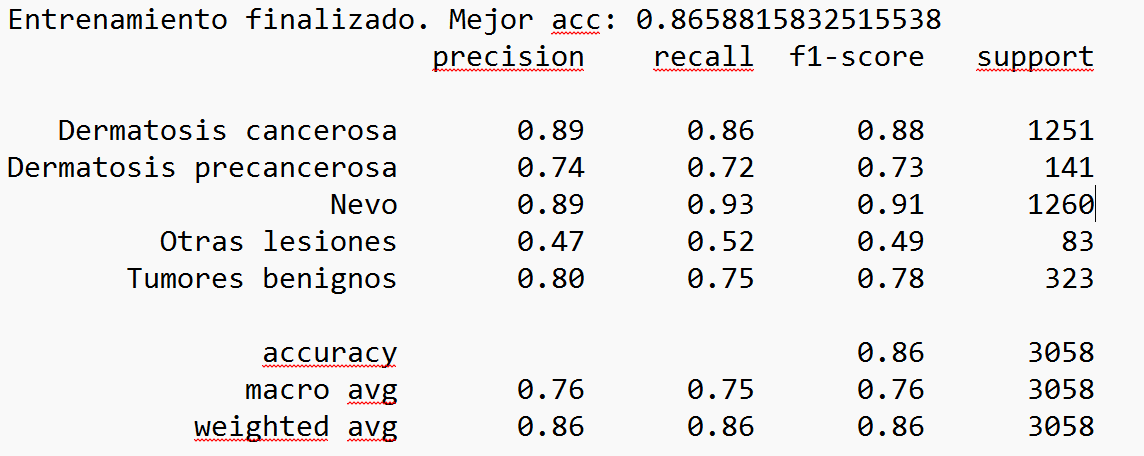

Observaciones:

El fine-tuning progresivo, los pesos de clase y el label smoothing ayudaron a que el modelo generalice mejor y aprenda las clases minoritarias sin perder precisión en las mayoritarias.

El modelo alcanzó una precisión muy alta (99.7%) en entrenamiento, lo que sugiere que está bien aprendido, pero el val_loss subió un poco → esto indica ligero sobreajuste, aunque el early stopping lo detuvo a tiempo.

La clase más difícil sigue siendo “Otras lesiones”, probablemente por pocos ejemplos y alta variabilidad visual.

*Pasos que se pueden seguir:*

MixUp o CutMix → técnicas de regularización que reducen el leve sobreajuste y mejoran la robustez.

Fine-tuning con menor LR (1e-6) por unas 5 épocas más desde el modelo (best_vit35.pth) → puede subir el macro F1.

1. Reentrenar desde el mejor modelo

Cargá best_vit35.pth y continuá 5 a 10 épocas más con:  
`optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)`  
`scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)`

→ LR bajo = pequeños ajustes, no memoriza ruido.

2. Agregar MixUp o CutMix

Genera imágenes híbridas (mezcla de dos muestras + etiquetas interpoladas) y aumenta la generalización.
Con eso, incluso si el val_loss sube levemente, el modelo será más robusto.

3. Early stopping más estricto

Reducí la paciencia (de 7 a 3) para cortar rápido si el val_loss sube dos veces seguidas.

In [ ]:
import os, random, gc
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from PIL import Image

# ==============================
# CONFIGURACIÓN
# ==============================
class CFG:
    seed: int = 42
    img_size: int = 224
    batch_size = 32
    num_workers = 0
    num_epochs: int = 10   # solo unas pocas épocas
    lr: float = 1e-6       # aprendizaje suave
    model_name: str = "vit_base_patch16_224"
    pretrained: bool = False   # cargamos pesos previos, no preentrenados

    if os.path.exists("/scratch/llencinas/Clasificado_menosNEVOS"):
        images_root: str = "/scratch/llencinas/Clasificado_menosNEVOS"
    elif os.path.exists("/users/llencinas/Clasificado_menosNEVOS"):
        images_root: str = "/users/llencinas/Clasificado_menosNEVOS"
    elif os.path.exists("/content/Clasificado_local"):
        images_root: str = "/content/Clasificado_local"
    else:
        raise FileNotFoundError("No se encontró el dataset.")

    val_split: float = 0.1
    test_split: float = 0.1
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CFG.seed)

# ==============================
# FUNCIONES AUXILIARES
# ==============================
def mixup_data(x, y, alpha=0.4):
    '''Aplica MixUp a un batch'''
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(CFG.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ==============================
# DATOS
# ==============================
full_ds = datasets.ImageFolder(CFG.images_root)
X = [s[0] for s in full_ds.samples]
y = [s[1] for s in full_ds.samples]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=CFG.val_split+CFG.test_split, stratify=y, random_state=CFG.seed)
relative_test_size = CFG.test_split / (CFG.val_split + CFG.test_split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=relative_test_size, stratify=y_temp, random_state=CFG.seed)

transform = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = np.array(Image.open(self.paths[idx]).convert("RGB"))
        img = self.transform(image=img)["image"]
        label = self.labels[idx]
        return img, label

train_ds = SimpleDataset(X_train, y_train, transform)
val_ds = SimpleDataset(X_val, y_val, transform)
test_ds = SimpleDataset(X_test, y_test, transform)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

class_names = full_ds.classes

# ==============================
# MODELO Y CRITERIO
# ==============================
model = timm.create_model(
    CFG.model_name,
    pretrained=False,
    num_classes=len(class_names),
    drop_rate=0.3,
    attn_drop_rate=0.3
)
model.load_state_dict(torch.load("best_vit35.pth"))
model = model.to(CFG.device)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(weights, dtype=torch.float).to(CFG.device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.num_epochs)

# ==============================
# ENTRENAMIENTO (CON MIXUP)
# ==============================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
        imgs, targets_a, targets_b, lam = mixup_data(imgs, labels, alpha=0.4)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item())
        total += labels.size(0)
    return total_loss/total, correct/total

def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

# ==============================
# FASE 3: FINE-TUNING FINAL
# ==============================
print("===== Fase 3: Reentrenamiento fino con MixUp =====")

best_acc = 0
patience = 3
trigger = 0

for epoch in range(CFG.num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)
    scheduler.step()
    print(f"Epoch {epoch+1}/{CFG.num_epochs} - Train acc {tr_acc:.4f} | Val acc {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_fase3.pth")
        print(f"\ Nuevo mejor modelo guardado (acc={val_acc:.4f})")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print(f"EarlyStopping activado en epoch {epoch+1}")
            break

print("Entrenamiento finalizado. Mejor acc:", best_acc)

# ==============================
# EVALUACIÓN FINAL
# ==============================
model.load_state_dict(torch.load("best_vit_fase3.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(CFG.device), labels.to(CFG.device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

(venv) llencinas@nabucodonosor:~$ python3 vit_fase_3.py  
===== Fase 3: Reentrenamiento fino con MixUp =====  
Epoch 1/10 - Train acc 0.8545 | Val acc 0.8541  
Nuevo mejor modelo guardado (acc=0.8541)  
Epoch 2/10 - Train acc 0.8510 | Val acc 0.8587  
Nuevo mejor modelo guardado (acc=0.8587)  
Epoch 3/10 - Train acc 0.8467 | Val acc 0.8610  
Nuevo mejor modelo guardado (acc=0.8610)  
Epoch 4/10 - Train acc 0.8612 | Val acc 0.8590  
Epoch 5/10 - Train acc 0.8516 | Val acc 0.8620  
Nuevo mejor modelo guardado (acc=0.8620)  
Epoch 6/10 - Train acc 0.8391 | Val acc 0.8626  
Nuevo mejor modelo guardado (acc=0.8626)  
Epoch 7/10 - Train acc 0.8610 | Val acc 0.8656  
Nuevo mejor modelo guardado (acc=0.8656)  
Epoch 8/10 - Train acc 0.8476 | Val acc 0.8623  
Epoch 9/10 - Train acc 0.8524 | Val acc 0.8626  
Epoch 10/10 - Train acc 0.8409 | Val acc 0.8623  
EarlyStopping activado en epoch 10  
Entrenamiento finalizado. Mejor acc: 0.8655544651619235

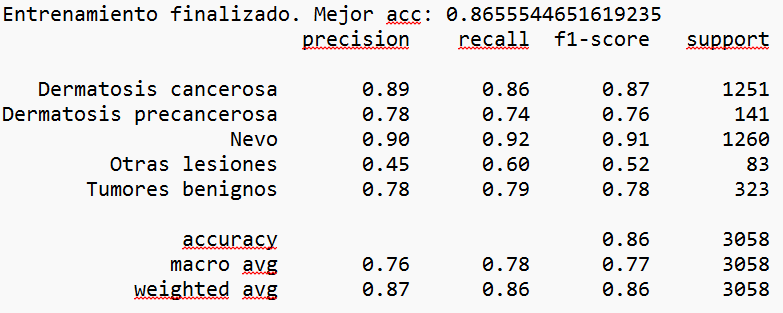

Resultados:
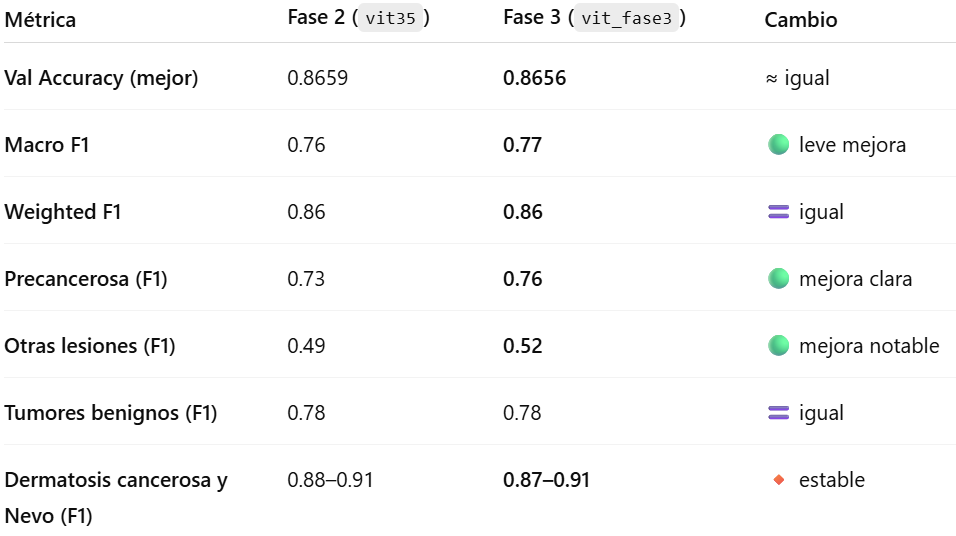

El accuracy global se mantuvo igual (0.865)

El macro F1 subió, lo que significa que el modelo ahora generaliza mejor entre clases desbalanceadas.

“Dermatosis precancerosa” y “Otras lesiones” aumentaron su F1, lo que indica que el MixUp logró su objetivo: reducir sobreajuste y mejorar la robustez en clases minoritarias.

El train acc se mantuvo entre 0.84–0.86, sin despegar demasiado del val acc → confirmación de menos sobreajuste que en vit35.py

# Explicaciones extras para mi

**Cálculo de Gradientes**

Un gradiente es la derivada de la función de pérdida respecto de cada uno de los parámetros del modelo (pesos y biases). Indica cómo cambiaría la pérdida si un parámetro se modifica ligeramente.

En una red neuronal:
- Los parámetros son los pesos y biases.
- La función que derivamos es la función de pérdida.
- El gradiente indica la dirección y magnitud del cambio necesario para disminuir esa pérdida.

El objetivo del entrenamiento es minimizar la pérdida. Para lograrlo, el optimizador (por ejemplo, Adam) utiliza los gradientes para actualizar los parámetros del modelo.
De manera general:
- Si el gradiente es positivo, el parámetro debe disminuir.
- Si el gradiente es negativo, el parámetro debe aumentar.
- Si es cercano a cero, el parámetro ya está cerca de un valor adecuado.

*Autodiferenciación en PyTorch*

PyTorch calcula los gradientes automáticamente mediante un sistema llamado autograd. El proceso funciona así:

- Se realiza una pasada hacia adelante (forward pass), donde la red produce predicciones.
- Se calcula la pérdida.
- Cuando se ejecuta loss.backward(), PyTorch aplica la regla de la cadena y obtiene las derivadas de la pérdida respecto de todos los pesos del modelo.
- El optimizador utiliza esos gradientes para actualizar los pesos.

Ejemplo conceptual: Supongamos una red muy simple con un único parámetro w:

La predicción es:
y_pred = w * x

La pérdida:
loss = (y_pred - y_true)**2

El cálculo del gradiente consiste en obtener d(loss)/d(w). Ese valor le indica al optimizador cómo modificar w para reducir la pérdida en la siguiente iteración.

*¿Qué sucede con torch.no_grad()?*

Durante la evaluación del modelo se utiliza:

`with torch.no_grad():`

Esto desactiva por completo el cálculo de gradientes. Las razones son:
- En evaluación no se actualizan los pesos.
- No se necesita calcular derivadas.
- Se reduce el uso de memoria.
- Se acelera la inferencia.

El modelo únicamente realiza la pasada hacia adelante para generar predicciones, sin almacenar información adicional para backpropagation.

Resumen

El cálculo de gradientes es el procedimiento mediante el cual PyTorch obtiene la derivada de la función de pérdida respecto de cada parámetro del modelo. Estos gradientes indican cómo deben ajustarse los pesos para minimizar la pérdida, y constituyen la base de la actualización a través de backpropagation. Durante la evaluación (torch.no_grad()), dicho cálculo se desactiva para optimizar el rendimiento, ya que los parámetros no se modifican.



*¿Qué son los biases en una red neuronal?*

En una red neuronal, cada neurona tiene dos tipos de parámetros que se pueden ajustar durante el entrenamiento: los pesos (weights) y los biases.

El bias es un valor adicional que se suma a la entrada ponderada de una neurona antes de aplicar la función de activación. Su función es permitir que la neurona pueda desplazar (“mover”) la función de activación hacia la izquierda o hacia la derecha. Esto le da a la red mayor flexibilidad para aprender patrones.

La operación típica dentro de una neurona es:

𝑧 = 𝑤 ⋅ 𝑥 + 𝑏

donde:

𝑤 son los pesos, que representan cuánto influye cada entrada,

𝑥 es la entrada,

𝑏 es el bias,

𝑧 es la suma ponderada que luego pasa por una función de activación como ReLU, sigmoid o softmax.

Sin el bias, la neurona siempre estaría obligada a pasar por el origen (0,0) y no podría ajustar correctamente funciones que necesiten un desplazamiento vertical.
En términos prácticos, el bias permite que la red aprenda funciones más complejas y se adapte mejor a los datos.

En resumen:
Los biases son parámetros adicionales que se aprenden junto con los pesos y que permiten a cada neurona ajustar su activación de forma más flexible, mejorando la capacidad de representación del modelo.